
Year: 1973 — A(t):
             tridactyla    aalge  lomvia
tridactyla     0.00013  0.00834 -0.0108
aalge          0.18546  0.01729 -0.2969
lomvia         0.17415  0.05440 -0.3221
Thresholds — Positive: 0.0761, Negative: 0.1430

Year: 1974 — A(t):
             tridactyla    aalge   lomvia
tridactyla     0.00015  0.01022 -0.01324
aalge          0.22734  0.02120 -0.36394
lomvia         0.21348  0.06668 -0.39483
Thresholds — Positive: 0.0933, Negative: 0.1753

Year: 1975 — A(t):
             tridactyla    aalge   lomvia
tridactyla     0.00014  0.00915 -0.01185
aalge          0.20341  0.01897 -0.32563
lomvia         0.19100  0.05966 -0.35327
Thresholds — Positive: 0.0835, Negative: 0.1569

Year: 1976 — A(t):
             tridactyla    aalge   lomvia
tridactyla     0.00011  0.00726 -0.00941
aalge          0.16153  0.01506 -0.25859
lomvia         0.15168  0.04738 -0.28054
Thresholds — Positive: 0.0663, Negative: 0.1246

Year: 1977 — A(t):
             tridactyla    aalge   lomvia
tridactyla

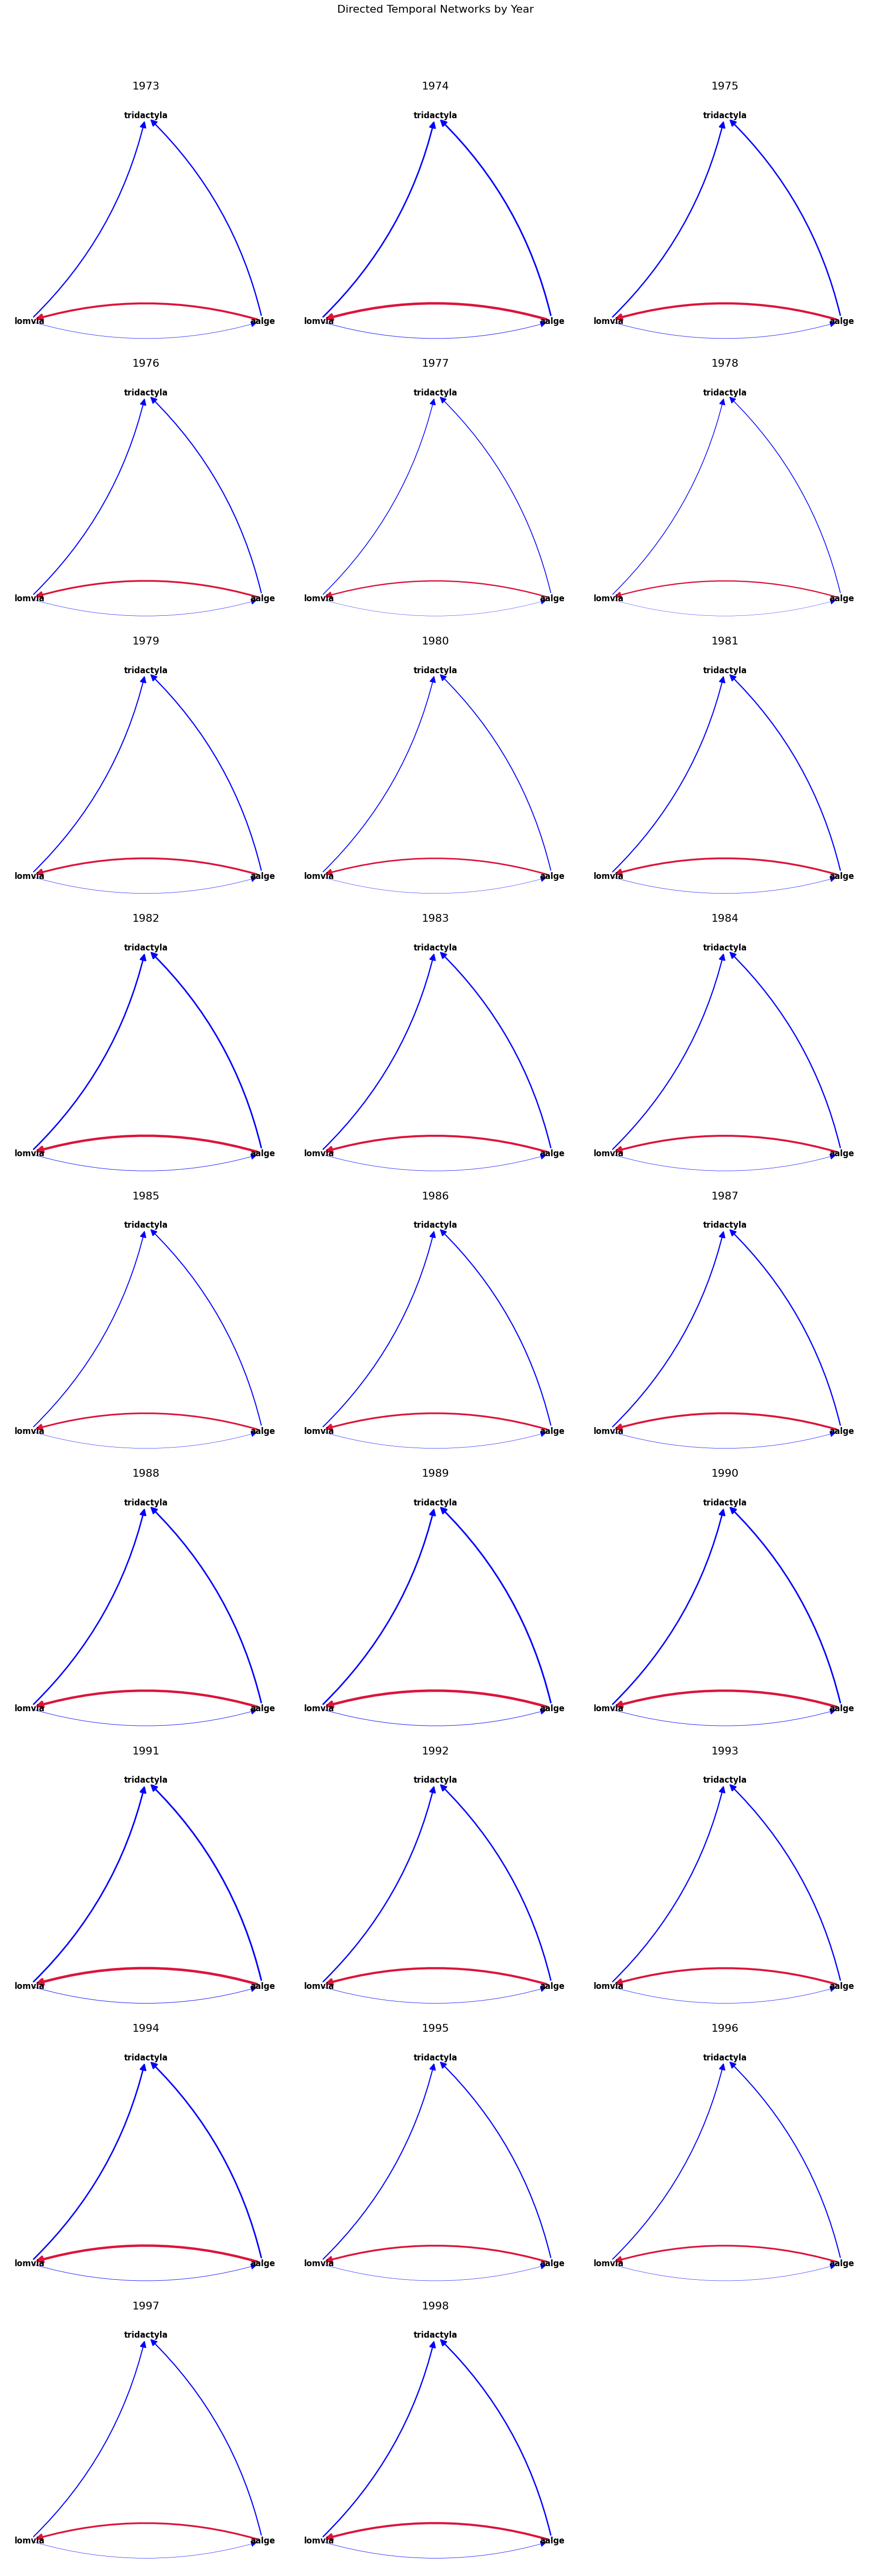

In [14]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math

# === PARAMETERS ===
folder_path = 'DIG_50'
layout_seed = 42
years = list(range(1973, 1999))  # Change according to dataset
np.random.seed(layout_seed)

# === LOAD MATRIX FUNCTION ===
def load_matrix_and_labels(path):
    df = pd.read_csv(path, index_col=0)
    original_labels = list(df.columns)
    short_labels = [label.split('_')[1] if '_' in label else label for label in original_labels]
    matrix = df.to_numpy(dtype=float)
    return matrix, original_labels, short_labels

# === LOAD DATA ===
A, original_labels, labels = load_matrix_and_labels(os.path.join(folder_path, 'matrix_A.csv'))  # A is unused now
B, _, _ = load_matrix_and_labels(os.path.join(folder_path, 'matrix_B.csv'))
P = np.transpose(pd.read_csv(os.path.join(folder_path, 'env.csv'), header=1).to_numpy(dtype=float))[1]

# === CHECKS ===
assert B.shape[0] == B.shape[1], "Matrix B must be square"
assert len(original_labels) == B.shape[0], "Label count must match matrix dimensions"
assert len(P) == len(years), "P(t) length must match number of years"

# === CUSTOM CLOCKWISE NODE POSITIONS ===
custom_order = [
    "Rissa_tridactyla",
    "Uria_aalge",
    "Uria_lomvia"
]
short_custom_order = [name.split('_')[1] for name in custom_order]
angle_step = 2 * np.pi / len(short_custom_order)
angles = [np.pi / 2 - i * angle_step for i in range(len(short_custom_order))]
pos = {label: (np.cos(angle), np.sin(angle)) for label, angle in zip(short_custom_order, angles)}

# === Initialize storage ===
average_weights = []
all_links = [(u, v) for i, u in enumerate(labels) for j, v in enumerate(labels) if i != j]
link_labels = [f"{u} → {v}" for u, v in all_links]
weight_matrix = pd.DataFrame(np.nan, index=link_labels, columns=years)

# === Prepare subplot grid ===
n_years = len(years)
n_cols = 3
n_rows = math.ceil(n_years / n_cols)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows))
axs = axs.flatten()

# === TEMPORAL NETWORK LOOP ===
for idx, (year, p_t) in enumerate(zip(years, P)):
    A_t = B * p_t
    A_t_df = pd.DataFrame(A_t, index=labels, columns=labels)
    print(f"\nYear: {year} — A(t):\n", A_t_df.round(5))
    
    # --- Extract off-diagonal values ---
    off_diag_mask = ~np.eye(A_t.shape[0], dtype=bool)
    A_off_diag = A_t[off_diag_mask]
    
    # --- Compute separate thresholds for positive and negative values ---
    positive_values = A_off_diag[A_off_diag > 0]
    negative_values = A_off_diag[A_off_diag < 0]
    
    pos_threshold = np.std(positive_values) if len(positive_values) > 0 else 0
    neg_threshold = np.std(negative_values) if len(negative_values) > 0 else 0
    
    print(f"Thresholds — Positive: {pos_threshold:.4f}, Negative: {neg_threshold:.4f}")
    
    # --- Build thresholded directed interaction graph ---
    G_t = nx.DiGraph()
    G_t.add_nodes_from(labels)
    
    for i, u in enumerate(labels):
        for j, v in enumerate(labels):
            if i == j:
                continue
            weight = A_t[i, j]
    
            # Apply asymmetric thresholding based on sign
            if (weight > 0 and weight > pos_threshold/2) or (weight < 0 and abs(weight) > abs(neg_threshold/2)):
                G_t.add_edge(u, v, weight=weight)
                weight_matrix.at[f"{u} → {v}", year] = weight
                
    active_weights = [abs(w['weight']) for _, _, w in G_t.edges(data=True)]
    average_weights.append(np.mean(active_weights) if active_weights else 0)

    ax = axs[idx]
    ax.set_title(f"{year}", fontsize=16)
    nx.draw_networkx_labels(G_t, pos, font_size=12, font_weight='bold', ax=ax)
    edges = G_t.edges(data=True)
    edge_weights = [abs(d['weight']) for (_, _, d) in edges]
    edge_colors = ['blue' if d['weight'] >= 0 else 'crimson' for (_, _, d) in edges]

    nx.draw_networkx_edges(
        G_t, pos,
        ax=ax,
        arrows=True,
        edge_color=edge_colors,
        width=[w * 10 for w in edge_weights],
        connectionstyle='arc3,rad=0.15',
        arrowsize=20
    )
    ax.axis('off')

# Hide unused subplots
for i in range(n_years, len(axs)):
    axs[i].axis('off')

plt.suptitle("Directed Temporal Networks by Year", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('matrices_BIRD_50.pdf')
plt.show()


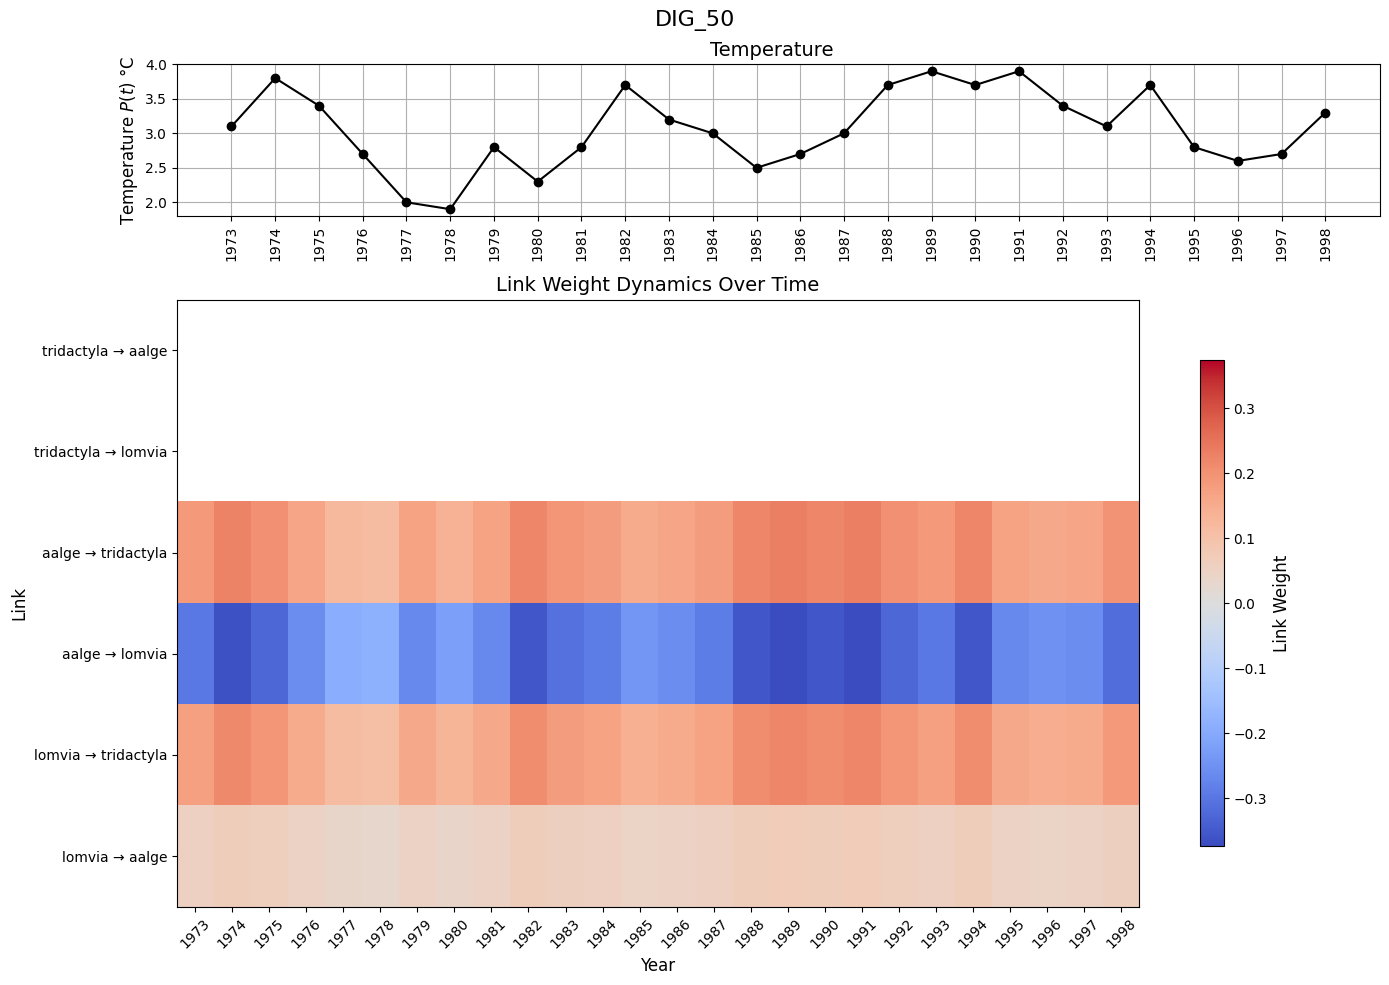

In [15]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# === 1. X-axis year setup ===
years = list(weight_matrix.columns)
link_labels = list(weight_matrix.index)

# === 2. Use raw P(t) ===
P_centered = P  # Already centered or raw as desired

# === 3. Plotting ===
fig, axs = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [1, 4]})
fig.suptitle('DIG_50', fontsize=16)

# --- Plot 1: Environmental Parameter ---
axs[0].plot(years, P, marker='o', color='black')
axs[0].set_title("Temperature  ", fontsize=14)
axs[0].set_ylabel("Temperature $P(t)$ °C ", fontsize=12)
axs[0].grid(True)
axs[0].set_xticks(years)
axs[0].set_xticklabels(years, rotation=90, fontsize=10)
# --- Plot 2: Heatmap of Link Weights (No Text) ---
absmax = np.nanmax(np.abs(weight_matrix.values))
vmin = -absmax
vmax = absmax

im = axs[1].imshow(weight_matrix.values, aspect='auto', cmap='coolwarm', vmin=vmin, vmax=vmax)

# No numeric annotations shown here

# Axes and labels
axs[1].set_yticks(np.arange(len(link_labels)))
axs[1].set_yticklabels(link_labels, fontsize=10)
axs[1].set_xticks(np.arange(len(years)))
axs[1].set_xticklabels(years, rotation=45)
axs[1].set_title("Link Weight Dynamics Over Time", fontsize=14)
axs[1].set_xlabel("Year", fontsize=12)
axs[1].set_ylabel("Link", fontsize=12)

# Colorbar
cbar = plt.colorbar(im, ax=axs[1], orientation='vertical', shrink=0.8)
cbar.set_label("Link Weight", fontsize=12)

# Final layout
plt.tight_layout()
plt.savefig("LinkDynamics_DIG_50.pdf", dpi=300)
plt.show()




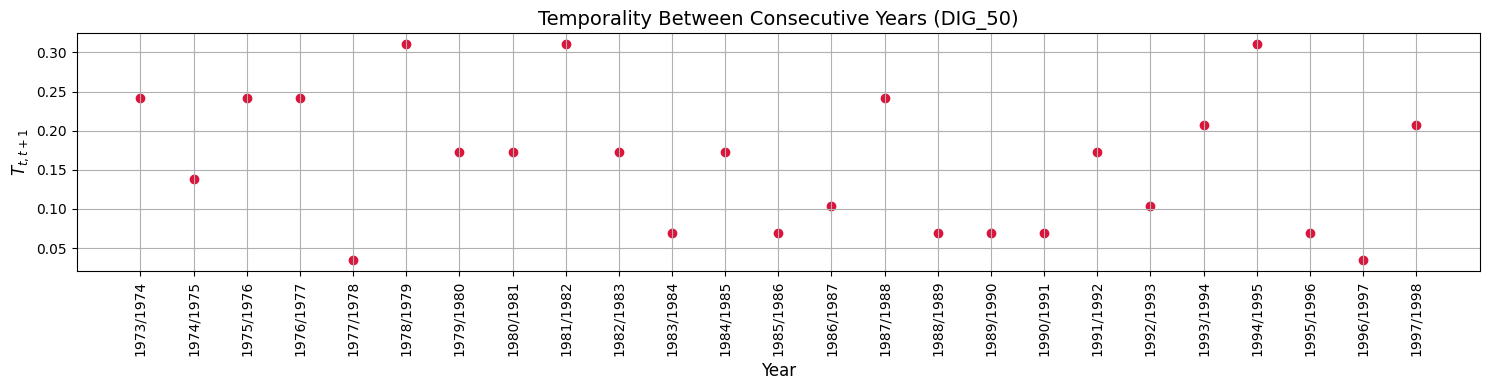

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def temporality_T(A_m, A_n):
    A_m = np.array(A_m)
    A_n = np.array(A_n)
    
    numerator = np.sum(np.abs(A_m - A_n))
    denominator = np.sum(np.maximum(A_m, A_n))
    
    return numerator #/ denominator if denominator != 0 else 0


# Generate time-evolving adjacency matrices
A_t = [ B * p_t for p_t in P]

# Compute temporality between consecutive years
T_consecutive = []
for i in range(len(A_t) - 1):
    T_consecutive.append(temporality_T(A_t[i], A_t[i + 1]))

# Corresponding x-axis: midpoints between years
year_pairs = [f"{years[i]}/{years[i+1]}" for i in range(len(years) - 1)]
P_jumps=P[1:]-P[0:len(P)-1]
# Plot the result
plt.figure(figsize=(15, 4))
plt.scatter(year_pairs, T_consecutive, marker='o', color='crimson')
plt.title("Temporality Between Consecutive Years (DIG_50)", fontsize=14)
plt.ylabel("$T_{t,t+1}$", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.xticks(rotation=90)  # Rotate year pairs vertically
plt.grid(True)
plt.tight_layout()
plt.savefig('Temporality_BIRD_50.pdf')
plt.show()


/tmp/ipykernel_39710/1555257718.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


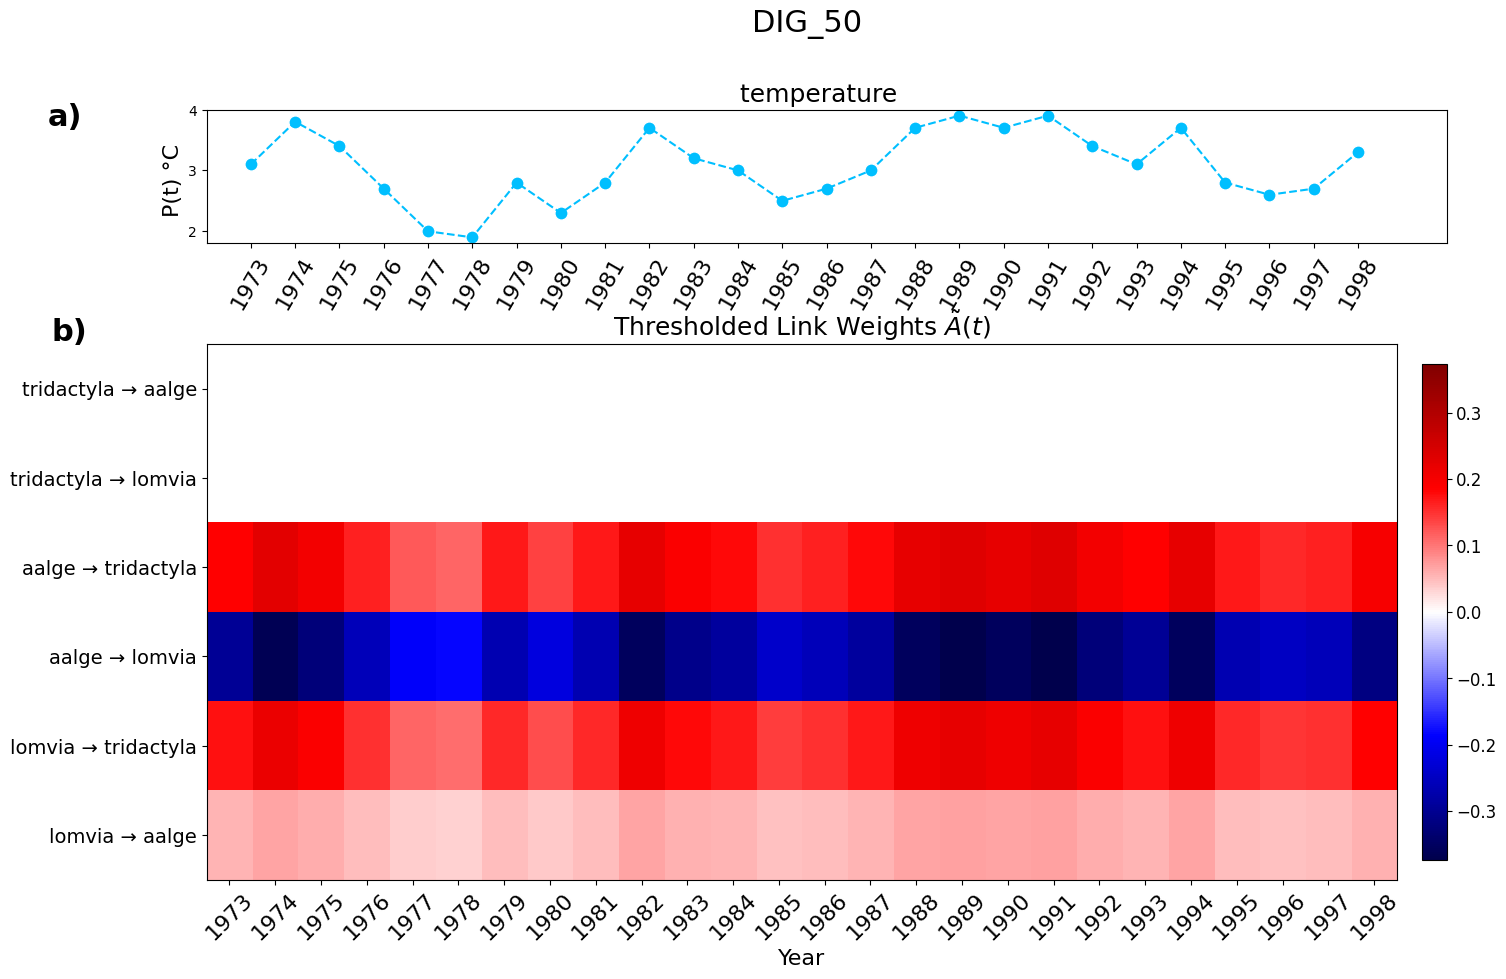

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import matplotlib.font_manager as fm

# === Use default style and try loading Roboto ===
plt.style.use('default')
try:
    roboto = fm.FontProperties(fname='Roboto.ttf')
except:
    roboto = None  # fallback to default

# === Data Preparation ===
year_pairs = [f"{years[i]}–{years[i+1]}" for i in range(len(years) - 1)]
P_jumps = P[1:] - P[:-1]

sign_change_counts = [0]
previous_signs = weight_matrix[years[0]].apply(np.sign)
for y in years[1:]:
    current_signs = weight_matrix[y].apply(np.sign)
    changes = (current_signs != previous_signs) & ~(current_signs.isna() | previous_signs.isna())
    sign_change_counts.append(changes.sum())
    previous_signs = current_signs

appearance_counts = [0]
disappearance_counts = [0]
prev_active = weight_matrix[years[0]].notna()
for y in years[1:]:
    curr_active = weight_matrix[y].notna()
    appearance = curr_active & ~prev_active
    disappearance = ~curr_active & prev_active
    appearance_counts.append(appearance.sum())
    disappearance_counts.append(disappearance.sum())
    prev_active = curr_active

fraction_positive_links = [
    (weight_matrix[y].dropna() > 0).sum() / len(weight_matrix[y].dropna()) if len(weight_matrix[y].dropna()) else 0
    for y in years
]

# === Plotting ===
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 1, height_ratios=[1, 4], hspace=0.3)

# --- 1. Rainfall (Top) ---
ax0 = fig.add_subplot(gs[0])
ax0.plot(years, P, color='deepskyblue', linestyle='--')
ax0.scatter(years, P, s=90, color='deepskyblue', edgecolors='white')
ax0.set_title("temperature  ", fontsize=18)
ax0.set_ylabel("P(t) °C ", fontsize=16)
ax0.set_xticks(years)
ax0.set_xlim([1972,2000])
ax0.set_xticklabels(years, rotation=60, fontsize=16)  # <-- vertical year labels
#ax0.grid(True)

# --- 2. Heatmap of Link Weights (Bottom) ---
ax1 = fig.add_subplot(gs[1])

color_matrix = weight_matrix.copy()
cmap = plt.get_cmap('seismic')  # red-white-blue
vmin = -np.nanmax(np.abs(color_matrix.values))
vmax = -vmin
im = ax1.imshow(color_matrix.values, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)

ax1.set_yticks(np.arange(len(link_labels)))
ax1.set_yticklabels(link_labels, fontsize=14)
ax1.set_xticks(np.arange(len(years)))
ax1.set_xticklabels(years, rotation=45, fontsize=16)
ax1.set_title("Thresholded Link Weights $\\tilde{A}(t)$", fontsize=18)
ax1.set_xlabel("Year", fontsize=16)

# Colorbar for the heatmap
cbar = fig.colorbar(im, ax=ax1, orientation='vertical', fraction=0.02, pad=0.02)
#cbar.set_label("Link Weight", fontsize=14)
cbar.ax.tick_params(labelsize=12)

# === Final Layout ===
fig.suptitle("DIG_50", fontsize=22)
plt.tight_layout(rect=[0, 0, 1, 0.95])
ax0.text(-0.1, 1.05, 'a)', transform=ax0.transAxes, fontsize=22, fontweight='bold', va='top', ha='right')
ax1.text(-0.1, 1.05, 'b)', transform=ax1.transAxes, fontsize=22, fontweight='bold', va='top', ha='right')
plt.savefig("Links_DIG_50_reordered.pdf", dpi=300)
plt.show()
